In [1]:
import os

os.chdir(r"C:\Users\ulloa-to\git\Advanced_Remote_sensing_HM\week_1\data/")

In [3]:
import rasterio

raster = rasterio.open("LC08_L1TP_174037_20180904_20180912_01_T1/LC08_L1TP_174037_20180904_20180912_01_T1_B5.TIF")

print(raster.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 7551, 'height': 7691, 'count': 1, 'crs': CRS.from_epsg(32636), 'transform': Affine(30.0, 0.0, 649485.0,
       0.0, -30.0, 3789315.0), 'tiled': False, 'interleave': 'band'}


In [4]:
raster.count

1

In [6]:
print("The CRS of my raster is:", raster.crs)

The CRS of my raster is: EPSG:32636


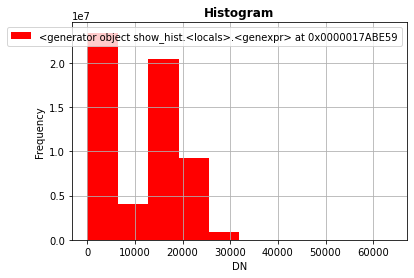

In [7]:
from rasterio.plot import show_hist

show_hist(raster)

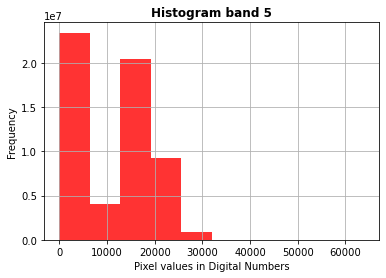

In [12]:
import matplotlib.pyplot as plt

fig, axhist = plt.subplots(1,1)
show_hist(raster, ax = axhist, title = "Histogram band 5", alpha = 0.8)
axhist.set_xlabel("Pixel values in Digital Numbers")
axhist.set_ylabel("Frequency")
axhist.get_legend().remove()
plt.show()

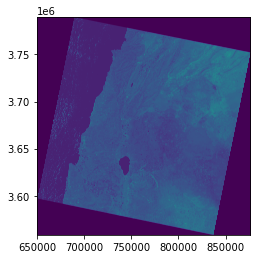

<AxesSubplot:>

In [15]:
from rasterio.plot import show
show(raster)

In [17]:
# stack

import osgeo
from osgeo import gdal_array
import gdal

# load bands as array
b2 = gdal_array.LoadFile("LC08_L1TP_174037_20180904_20180912_01_T1/LC08_L1TP_174037_20180904_20180912_01_T1_B2.TIF")
b3 = gdal_array.LoadFile("LC08_L1TP_174037_20180904_20180912_01_T1/LC08_L1TP_174037_20180904_20180912_01_T1_B3.TIF")
b4 = gdal_array.LoadFile("LC08_L1TP_174037_20180904_20180912_01_T1/LC08_L1TP_174037_20180904_20180912_01_T1_B4.TIF")
b5 = gdal_array.LoadFile("LC08_L1TP_174037_20180904_20180912_01_T1/LC08_L1TP_174037_20180904_20180912_01_T1_B5.TIF")

# load band for geo info
bandgeo = gdal.Open("LC08_L1TP_174037_20180904_20180912_01_T1/LC08_L1TP_174037_20180904_20180912_01_T1_B2.TIF")


In [20]:
y_pix, x_pix = b2.shape
driver = gdal.GetDriverByName("GTiff")
geotrans = bandgeo.GetGeoTransform()
proj = bandgeo.GetProjection()

In [22]:
rOut = driver.Create("rgbn_stack.tif", x_pix, y_pix, 4, gdal.GDT_UInt16)
rOut.GetRasterBand(1).WriteArray(b2)
rOut.GetRasterBand(2).WriteArray(b3)
rOut.GetRasterBand(3).WriteArray(b4)
rOut.GetRasterBand(4).WriteArray(b5) 
rOut.SetGeoTransform(geotrans)
rOut.SetProjection(proj)
rOut.FlushCache()
rOut = None

In [ ]:
# vector: ogr, fiona, geopandas, shapely
# raster: rasterio, gdal

In [34]:
# cropping

import fiona
import rasterio.mask

with fiona.open("vector/aoi_beirut.shp", "r") as shapefile: 
    shapes = [feature["geometry"] for feature in shapefile]
    
with rasterio.open("rgbn_stack.tif", "r") as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop = True)
    out_meta = src.meta
    

In [30]:
out_transform

Affine(30.0, 0.0, 715815.0,
       0.0, -30.0, 3770085.0)

In [29]:
out_image.shape

(4, 1552, 1701)

In [35]:
out_meta.update({"driver": "GTiff",
                "height": out_image.shape[1],
                "width": out_image.shape[2],
               "transform": out_transform})

In [36]:
with rasterio.open("raster_cropped.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [40]:
# resampling band 5 and band 10

from rasterio.enums import Resampling

tirs_cr = rasterio.open("results/TIRS_crop_py.tif") # 100m

upscale_factor = 3/10

with rasterio.open("results/NIR_crop_py.tif") as dataset:
    
    data = dataset.read(out_shape = (dataset.count, 
                        int(dataset.height * upscale_factor), 
                        int(dataset.width * upscale_factor)),
                        resampling = Resampling.bilinear)
    transform = dataset.transform * dataset.transform.scale(
    (dataset.width / data.shape[-1]),
    (dataset.height / data.shape[-2]))
    
    data_meta = dataset.meta
    
    

In [41]:
data_meta.update({"driver": "GTiff",
                "height": data.shape[1],
                "width": data.shape[2],
               "transform": transform})

In [42]:
with rasterio.open("NIR_resampled.tif", "w", **data_meta) as dest:
    dest.write(data)

In [43]:
# Mosaicking

ntl1 = "NTL/VNP46A2.A2019100.h26v06.001.2021020141752_DNB_BRDF-Corrected_NTL.tif"
ntl2 = "NTL/VNP46A2.A2019100.h26v07.001.2021020141743_DNB_BRDF-Corrected_NTL.tif"

ntl_list = [ntl1, ntl2]

In [45]:
len(ntl_list)

2

In [46]:
outname = "mosaic.tif"
vrt = gdal.BuildVRT("mosaic.vrt", ntl_list)
gdal.Translate(outname, vrt)

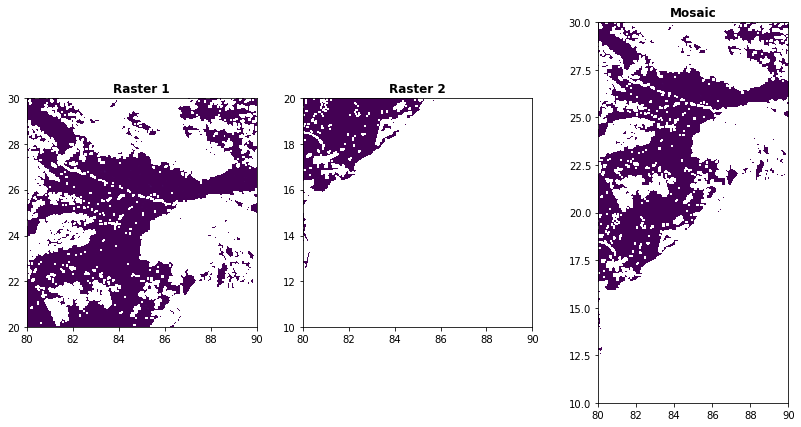

In [47]:
# plot 

r1 = rasterio.open(ntl1)
r2 = rasterio.open(ntl2)
mos = rasterio.open(outname)

fig4, (ax1, ax2, axmos) = plt.subplots(1, # rows                                     
                                       3, # columns
                                       figsize=(14,7))
show(r1,title="Raster 1",ax=ax1)
show(r2,title="Raster 2",ax=ax2)
show(mos,title="Mosaic",ax=axmos)
ax1.ticklabel_format(style = 'plain')
ax2.ticklabel_format(style = 'plain')
axmos.ticklabel_format(style = 'plain')